In [1]:
import numpy as np
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
import matplotlib.pylab as plt
import pickle
import sys
import os
from PIL import Image

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
# Data generator parameters
gen_params = {"featurewise_center":False,\
              "samplewise_center":False,\
              "featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,\
              "zca_whitening":False,\
              "rotation_range":20,\
              "width_shift_range":0.1,\
              "height_shift_range":0.1, \
              "shear_range":0.2, \
              "zoom_range":0.1,\
              "horizontal_flip":True,\
              "vertical_flip":True}

# Train and validation generators
train_gen = ImageDataGenerator(**gen_params, preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)
val_gen = ImageDataGenerator(**gen_params, preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)

class_names = ["Black", "Blue",  "Green", "Take-to-recycle"]

bs = 128 # batch size

train_generator = train_gen.flow_from_directory(
    directory = "/Users/mac/Desktop/ENEL645/Final Project/Garbage-dataset-pre-processed/Train",
    target_size=(224, 224),
    color_mode="rgb",
    classes= class_names,
    class_mode="categorical",
    batch_size=bs,
    shuffle=True,
    seed=42,
    interpolation="nearest",
)

validation_generator = val_gen.flow_from_directory(
    directory = "/Users/mac/Desktop/ENEL645/Final Project/Garbage-dataset-pre-processed/Validation",
    target_size=(224, 224),
    color_mode="rgb",
    classes= class_names,
    class_mode="categorical",
    batch_size=bs,
    shuffle=True,
    seed=42,
    interpolation="nearest",)

Found 5139 images belonging to 4 classes.
Found 1123 images belonging to 4 classes.


In [3]:
# model_name_it = "garbage_classifier_mn_50_it.h5"
# model_name_ft = "garbage_classifier_mn_50_ft.h5"

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)


# monitor_it = tf.keras.callbacks.ModelCheckpoint(model_name_it, monitor='val_loss',\
#                                              verbose=0,save_best_only=True,\
#                                              save_weights_only=False,\
#                                              mode='min')

# monitor_ft = tf.keras.callbacks.ModelCheckpoint(model_name_ft, monitor='val_loss',\
#                                              verbose=0,save_best_only=True,\
#                                              save_weights_only=False,\
#                                              mode='min')

def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)


def define_callbacks(model_name_it, model_name_ft ):
  # model_name_it = "garbage_classifier_vgg19_it.h5"
  # model_name_ft = "garbage_classifier_vgg19_ft.h5"

    monitor_it = tf.keras.callbacks.ModelCheckpoint(model_name_it, monitor='val_loss',\
                                                  verbose=0,save_best_only=True,\
                                                  save_weights_only=False,\
                                                  mode='min')
    monitor_ft = tf.keras.callbacks.ModelCheckpoint(model_name_ft, monitor='val_loss',\
                                                  verbose=0,save_best_only=True,\
                                                  save_weights_only=False,\
                                                  mode='min')
    return monitor_it, monitor_ft






In [6]:
monitor_it0, monitor_ft0 = define_callbacks("garbage_classifier_mn_freez_it.h5",  "garbage_classifier_mn_freez_ft.h5")
monitor_it1, monitor_ft1 = define_callbacks("garbage_classifier_mn_ufreez_it.h5",  "garbage_classifier_mn_ufreez_ft.h5")


In [4]:
# img_height = 224
# img_width = 224

# # Defining the model
# base_model = tf.keras.applications.MobileNet(
#     weights='imagenet',  # Load weights pre-trained on ImageNet.
#     input_shape=(img_height, img_width, 3),
#     include_top=False) 
# base_model.trainable = False

# x1 = base_model(base_model.input, training = False)
# x2 = tf.keras.layers.Flatten()(x1)


# out = tf.keras.layers.Dense(len(class_names),activation = 'softmax')(x2)
# model = tf.keras.Model(inputs = base_model.input, outputs =out)

# print("Initial Training Model")
# print(model.summary())

def build_model(class_names, training):
    
    img_height = 224
    img_width = 224
    
    # Defining the model
    base_model = tf.keras.applications.MobileNet(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        input_shape=(img_height, img_width, 3),
        include_top=False) 
    base_model.trainable = training
    x1 = base_model(base_model.input, training = training)
    x2 = tf.keras.layers.Flatten()(x1)
    out = tf.keras.layers.Dense(len(class_names),activation = 'softmax')(x2)
    model = tf.keras.Model(inputs = base_model.input, outputs =out)
    
    print("--------------------------------------------------------")
    print("Initial Training Model: ")
    print("Training: ", training)
    print(model.summary())
    return model

In [5]:
model0 = build_model(class_names, False)
model1 = build_model(class_names, True)

Metal device set to: Apple M1 Max


2022-03-31 22:35:28.088552: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-31 22:35:28.088725: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


--------------------------------------------------------
Initial Training Model: 
Training:  False
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 4)                 200708    
                                                                 
Total params: 3,429,572
Trainable params: 200,708
Non-trainable params: 3,228,864
_________________________________________________________________
None
-------

In [9]:
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# history_it = model.fit(train_generator, epochs=10, verbose = 1, \
#                        callbacks= [early_stop, monitor_it, lr_schedule], \
#                        validation_data = (validation_generator))

def fit_it_model(monitor_it, model, epochs):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    history_it = model.fit(train_generator, epochs=epochs, verbose = 1, \
                        callbacks= [early_stop, monitor_it, lr_schedule], \
                        validation_data = (validation_generator))
    return history_it



In [10]:
history_it0 = fit_it_model(monitor_it0, model0, 50)
history_it1 = fit_it_model(monitor_it1, model1, 50)

2022-03-31 19:10:41.702109: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50


2022-03-31 19:10:42.051143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - ETA: 0s - loss: 1.1042 - accuracy: 0.6655

2022-03-31 19:11:13.351619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 39s 930ms/step - loss: 1.1042 - accuracy: 0.6655 - val_loss: 0.8823 - val_accuracy: 0.7311 - lr: 1.0000e-04
Epoch 2/50
41/41 [==============================] - 37s 906ms/step - loss: 0.6182 - accuracy: 0.7943 - val_loss: 0.8047 - val_accuracy: 0.7516 - lr: 1.0000e-04
Epoch 3/50
41/41 [==============================] - 38s 916ms/step - loss: 0.5290 - accuracy: 0.8206 - val_loss: 0.7417 - val_accuracy: 0.7711 - lr: 1.0000e-04
Epoch 4/50
41/41 [==============================] - 38s 919ms/step - loss: 0.4956 - accuracy: 0.8260 - val_loss: 0.7579 - val_accuracy: 0.7774 - lr: 1.0000e-04
Epoch 5/50
41/41 [==============================] - 38s 918ms/step - loss: 0.4217 - accuracy: 0.8490 - val_loss: 0.7506 - val_accuracy: 0.7774 - lr: 1.0000e-04
Epoch 6/50
41/41 [==============================] - 38s 920ms/step - loss: 0.3876 - accuracy: 0.8655 - val_loss: 0.7362 - val_accuracy: 0.7640 - lr: 1.0000e-04
Epoch 7/50
41/41 [==============================] -

2022-03-31 19:37:05.463654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - ETA: 0s - loss: 1.0271 - accuracy: 0.6984

2022-03-31 19:37:38.008745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 40s 957ms/step - loss: 1.0271 - accuracy: 0.6984 - val_loss: 0.9250 - val_accuracy: 0.7444 - lr: 1.0000e-04
Epoch 2/50
41/41 [==============================] - 39s 951ms/step - loss: 0.5619 - accuracy: 0.8286 - val_loss: 0.9064 - val_accuracy: 0.7533 - lr: 1.0000e-04
Epoch 3/50
41/41 [==============================] - 39s 941ms/step - loss: 0.5156 - accuracy: 0.8406 - val_loss: 0.7884 - val_accuracy: 0.7747 - lr: 1.0000e-04
Epoch 4/50
41/41 [==============================] - 39s 938ms/step - loss: 0.3857 - accuracy: 0.8735 - val_loss: 0.8086 - val_accuracy: 0.7809 - lr: 1.0000e-04
Epoch 5/50
41/41 [==============================] - 39s 941ms/step - loss: 0.3225 - accuracy: 0.8910 - val_loss: 0.8132 - val_accuracy: 0.7890 - lr: 1.0000e-04
Epoch 6/50
41/41 [==============================] - 39s 951ms/step - loss: 0.2872 - accuracy: 0.9013 - val_loss: 0.7327 - val_accuracy: 0.8023 - lr: 1.0000e-04
Epoch 7/50
41/41 [==============================] -

In [12]:
# it_file = open("it_history.pkl", "wb")
# pickle.dump(history_it.history, it_file)
# it_file.close()

# plt.figure()
# plt.plot(history_it.history["val_loss"], label = "Val loss")
# plt.plot(history_it.history["loss"], label = "Train loss")
# plt.legend()
# plt.show()
# plt.figure()
# plt.plot(history_it.history["val_accuracy"], label = "Val accuracy")
# plt.plot(history_it.history["accuracy"], label = "Accuracy")
# plt.legend()
# plt.show()
def plot_it_history(history_it, it_file_name):
    print("--------------------------------------------------------")
    print(it_file_name)
    print("--------------------------------------------------------")
    
    it_file = open(it_file_name, "wb")
    pickle.dump(history_it.history, it_file)
    it_file.close()

    plt.figure()
    plt.plot(history_it.history["val_loss"], label = "Val loss")
    plt.plot(history_it.history["loss"], label = "Train loss")
    plt.title('Initial model loss')
    plt.xlabel("Epoch (iteration)")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(history_it.history["val_accuracy"], label = "Val accuracy")
    plt.plot(history_it.history["accuracy"], label = "Train Accuracy")
    plt.title('Initial model accuracy')
    plt.xlabel("Epoch (iteration)")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    

--------------------------------------------------------
it_history0.pkl
--------------------------------------------------------


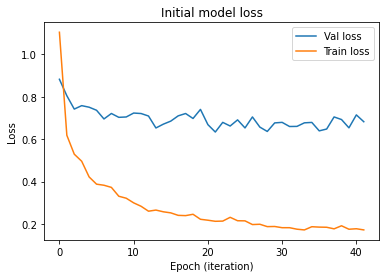

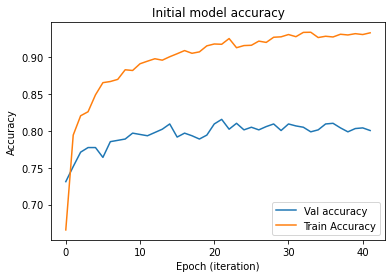

--------------------------------------------------------
it_history1.pkl
--------------------------------------------------------


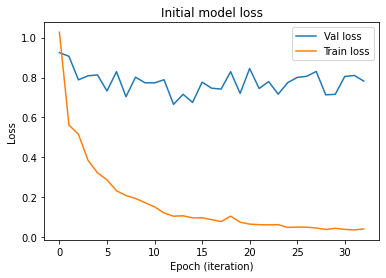

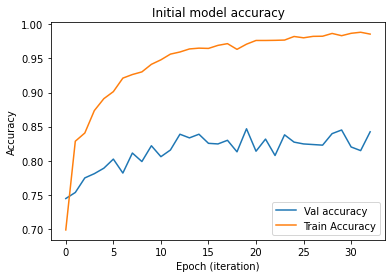

In [13]:
plot_it_history(history_it0, "it_history0.pkl")
plot_it_history(history_it1, "it_history1.pkl")

In [26]:


# Fine-tuning the model
model_name_it_0 = "garbage_classifier_mn_freez_it.h5"
model = tf.keras.models.load_model(model_name_it_0)
model.trainable = True

print("Fine-tuning model")
print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-8),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history_ft_0 = model.fit(train_generator, epochs=5, verbose = 1, \
                       callbacks= [early_stop, monitor_ft0, lr_schedule], \
                       validation_data = (validation_generator))

Fine-tuning model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 4)                 200708    
                                                                 
Total params: 3,429,572
Trainable params: 3,407,684
Non-trainable params: 21,888
_________________________________________________________________
None
Epoch 1/5


2022-03-31 20:17:18.624085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - ETA: 0s - loss: 0.1919 - accuracy: 0.9290

2022-03-31 20:17:50.800428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 40s 943ms/step - loss: 0.1919 - accuracy: 0.9290 - val_loss: 0.6450 - val_accuracy: 0.8130 - lr: 1.0000e-08
Epoch 2/5
41/41 [==============================] - 38s 933ms/step - loss: 0.2135 - accuracy: 0.9202 - val_loss: 0.6416 - val_accuracy: 0.8103 - lr: 1.0000e-08
Epoch 3/5
41/41 [==============================] - 39s 936ms/step - loss: 0.2056 - accuracy: 0.9196 - val_loss: 0.6667 - val_accuracy: 0.7970 - lr: 1.0000e-08
Epoch 4/5
41/41 [==============================] - 39s 934ms/step - loss: 0.2135 - accuracy: 0.9171 - val_loss: 0.6636 - val_accuracy: 0.8032 - lr: 1.0000e-08
Epoch 5/5
41/41 [==============================] - 39s 937ms/step - loss: 0.2011 - accuracy: 0.9220 - val_loss: 0.6502 - val_accuracy: 0.8103 - lr: 1.0000e-08


In [29]:
# history_ft0 = fine_tune_model("garbage_classifier_mn_freez_it.h5", monitor_ft0)
# history_ft1 = fine_tune_model("garbage_classifier_mn_ufreez_it.h5", monitor_ft1)


In [27]:
def plot_it_history(history_ft, ft_file_name):
    print("--------------------------------------------------------")
    print(ft_file_name)
    print("--------------------------------------------------------")

    plt.figure()
    plt.plot(history_ft.history["val_loss"], label = "Val loss")
    plt.plot(history_ft.history["loss"], label = "Train loss")
    plt.title('Fine-tuned model loss')
    plt.xlabel("Epoch (iteration)")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(history_ft.history["val_accuracy"], label = "Val accuracy")
    plt.plot(history_ft.history["accuracy"], label = "Train Accuracy")
    plt.title('Fine-tuned model accuracy')
    plt.xlabel("Epoch (iteration)")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # ft_file = open("ft_history.pkl", "wb")
    ft_file = open(ft_file_name, "wb")
    pickle.dump(history_ft.history, ft_file)
    ft_file.close()

--------------------------------------------------------
ft_history_0.pkl
--------------------------------------------------------


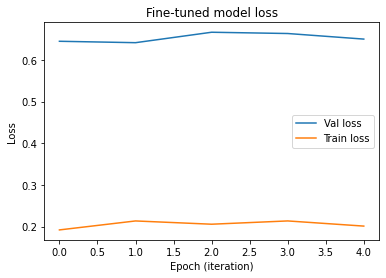

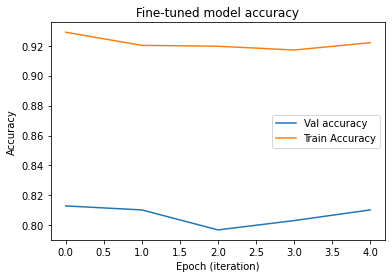

In [28]:
plot_it_history(history_ft_0, "ft_history_0.pkl")
# plot_it_history(history_ft2, "ft_history2.pkl")


In [8]:


test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)

test_generator = train_gen.flow_from_directory(
    directory = "/Users/mac/Desktop/ENEL645/Final Project/Garbage-dataset-pre-processed/Test",
    target_size=(224, 224),
    color_mode="rgb",
    classes= class_names,
    class_mode="categorical",
    batch_size=bs,
    shuffle=True,
    seed=42,
    interpolation="nearest",
)

Found 807 images belonging to 4 classes.


In [9]:
def test_it_model(model_name_it):
    # Testing the model in the initial training
    model = tf.keras.models.load_model(model_name_it)
    model.evaluate(test_generator)
    metrics = model.evaluate(test_generator)
    print("Model Name", model.name)
    print("Categorical cross-entropy:", round(metrics[0], 3))
    print("Accuracy:", round(metrics[1]*100, 2),'%')
    
def test_ft_model(model_name_ft):
    # Testing the model in the fine tuning
    model = tf.keras.models.load_model(model_name_ft)
    model.evaluate(test_generator)
    metrics = model.evaluate(test_generator)
    print("Model Name", model.name)
    print("Categorical cross-entropy:", round(metrics[0], 3))
    print("Accuracy:", round(metrics[1]*100, 2),'%')

In [10]:
test_it_model("garbage_classifier_mn_freez_it.h5")
test_it_model("garbage_classifier_mn_ufreez_it.h5")
test_ft_model("garbage_classifier_mn_freez_ft.h5")
# test_ft_model("garbage_classifier_mn_ufreez_ft.h5")

2022-03-31 22:35:58.364780: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-31 22:35:58.464434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 5s 670ms/step - loss: 0.6802 - accuracy: 0.7732
Model Name model
Categorical cross-entropy: 0.68
Accuracy: 77.32 %


2022-03-31 22:36:11.187575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 5s 671ms/step - loss: 0.7255 - accuracy: 0.8104
Model Name model_1
Categorical cross-entropy: 0.725
Accuracy: 81.04 %


2022-03-31 22:36:25.356752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 5s 664ms/step - loss: 0.7576 - accuracy: 0.7695
Model Name model
Categorical cross-entropy: 0.758
Accuracy: 76.95 %


2022-03-31 22:36:40.269914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Number of wrong predictions:  100


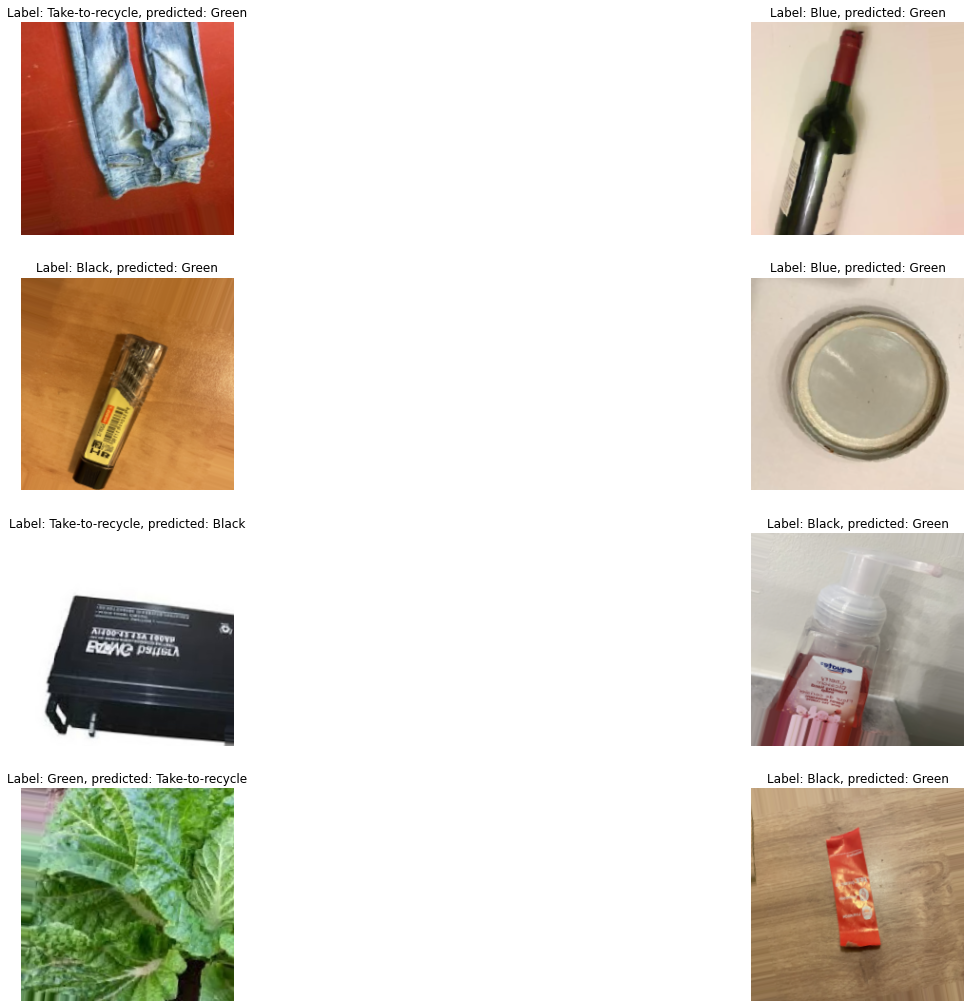

In [11]:
Xtest,Ytest = test_generator.__getitem__(0)
Ytest = Ytest.argmax(axis = 1) # get the label
Ypred = model0.predict(Xtest).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Ytest)[0]

print("Number of wrong predictions: ", wrong_indexes.size)

sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 8, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(4,2,ii+1)
    aux = Xtest[wrong_indexes[jj]]
    aux = (aux - aux.min())/(aux.max() - aux.min())
    plt.imshow(aux, cmap = "gray")
    plt.axis("off")
    plt.title("Label: %s, predicted: %s" %(class_names[Ytest[wrong_indexes[jj]]],class_names[Ypred[wrong_indexes[jj]]]))
plt.show()

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import itertools

def plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
  
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return


def plot_confusion_matrix_with_default_options(y_pred, y_true, classes):
    '''Plot a confusion matrix heatmap with a default size and default options.'''
    cm = confusion_matrix(y_true, y_pred)
    with sns.axes_style('ticks'):
        plt.figure(figsize=(12, 12))
        plot_confusion_matrix(cm, classes)
        plt.show()
    return

def print_report_conf_matrix(model):
    print("--------------------------------------------------------")
    print(model.name)
    print("--------------------------------------------------------")
    Ypred = model.predict(Xtest).argmax(axis = 1)
    report = classification_report(Ytest, Ypred)
    print(report)
    plot_confusion_matrix_with_default_options(Ypred, Ytest, class_names)

--------------------------------------------------------
model
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.31      0.24      0.27        34
           1       0.33      0.09      0.14        34
           2       0.18      0.36      0.24        28
           3       0.19      0.22      0.21        32

    accuracy                           0.22       128
   macro avg       0.25      0.22      0.21       128
weighted avg       0.26      0.22      0.21       128

Confusion matrix, without normalization


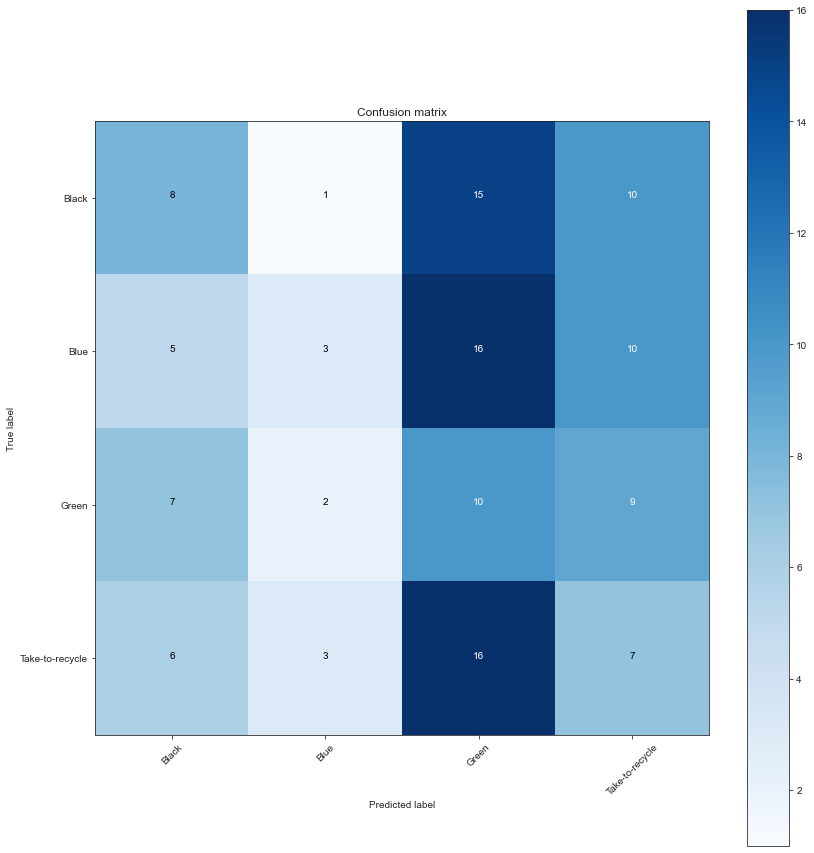

--------------------------------------------------------
model_1
--------------------------------------------------------


2022-03-31 22:36:49.402747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.14      0.12      0.13        34
           1       0.21      0.12      0.15        34
           2       0.18      0.29      0.22        28
           3       0.38      0.44      0.41        32

    accuracy                           0.23       128
   macro avg       0.23      0.24      0.23       128
weighted avg       0.23      0.23      0.22       128

Confusion matrix, without normalization


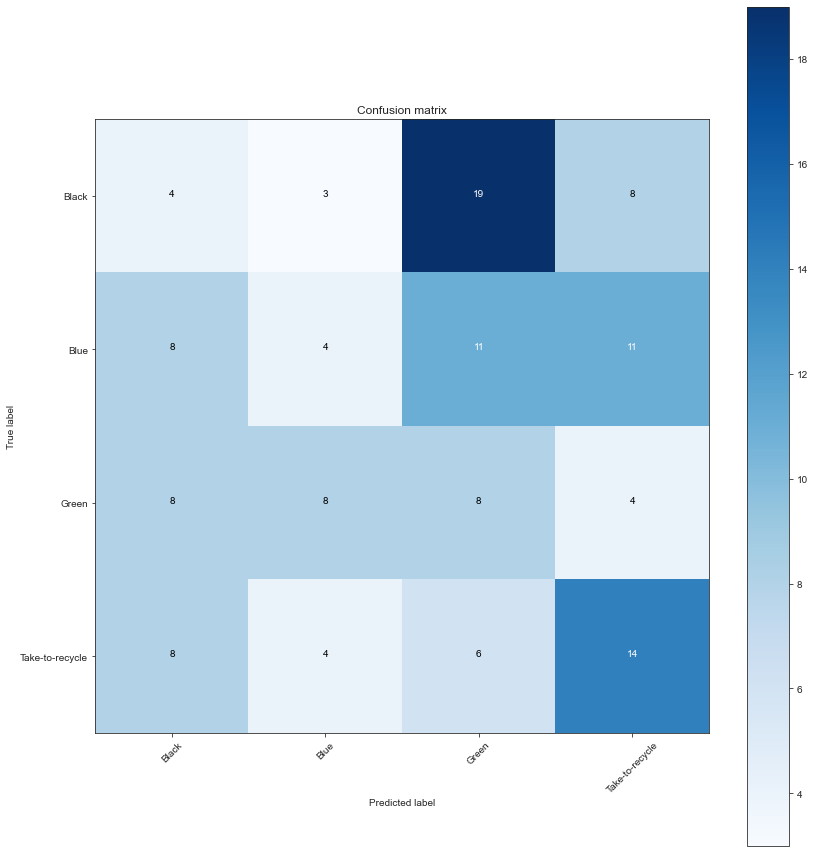

In [13]:
print_report_conf_matrix(model0)
print_report_conf_matrix(model1)
